# Qubit Optimization for 3-qubit ising model. 

We will be comparing pennylane gradient descent optimizer with that of Tensorflow and Pytorch optimizer for this quantum system. Ising model is an example of a system whose optimization landscape is non-convex and hence using gradient descent is not the best solution since the optimization can get stuck in local minimas. Quantum annealing (for example on D-wave system) can be used instead. 

The energy for this system is given by:
$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$

where each spin can be in +1 or -1 state and $J_{ij}$ are nearest neighbour coupling strengths.

For simplicity, we will assume that spin 1 is always in up state (+1 eigenstate of pauli-z operator)



# Pennylane optimizer

In [1]:
#import pennlane library

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer

In [2]:
# create our three devices. 

dev1 = qml.device('default.qubit', wires=3)
dev2 = qml.device('default.qubit', wires=3)
dev3 = qml.device('default.qubit', wires=3)

In [3]:
#We can use the GENERAL Pennylane Rot(phi,theta,omega,wires) single qubit operation
@qml.qnode(dev1)
def circuit1(p1, p2):
    qml.Rot(p1[0],p1[1],p1[2], wires =1)
    qml.Rot(p2[0],p2[1],p2[2], wires =2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

# the expectation value of pauliZ is plus 1 for spin up and -1 for spin down.

Our cost function is the energy of the spin configuration which we will optimize using gradient descent.

Let the coupling matrix be J = [1,-1]

In [4]:
def cost1(var):
    spins = circuit1(var[0],var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

Lets test these functions for [1,-1,-1] spin configuration. 

Total energy for this ising model should be

$H = -1(J1.s1.s2 + J2.s2.s3) = -1 (1*1*-1 + -1*-1*-1) = 2 $


In [5]:
#You can easily guess the angles if you look at the Rot(phi,theta,omega)

t1 = np.array([0, np.pi, 0])    #spin 2 in -1 state
t2 = np.array([0,np.pi ,0])     #spin 3 in -1 state
print(cost1([t1,t2]))

2.0


Now we optimize using pennylane numpy gradient descent optimizer


In [6]:
#initialize the parameters to some random values

pl1 = np.pi*(np.random.ranf(3))
pl2 = np.pi*(np.random.ranf(3))
var_init = np.array([pl1,pl2])
cost_init = cost1(var_init)
print(cost_init)

0.02523939334039471


The minimun energy should be -2 for [1,1,-1] spin configuration which corresponds to the angles of [0,0,0] and [0,pi,0] for the spin 2 and spin 3 respectively. 

In [7]:
gd = GradientDescentOptimizer(0.4)

var = var_init
var_gd = [var]
cost_gd = [cost_init]

for it in range(100):
    var = gd.step(cost1, var)
    if (it + 1) % 5 == 0:
        var_gd.append(var)
        cost_gd.append (cost1(var))
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, cost1(var), var))

Energy after step     5:  0.0006662 | Angles: [[2.91742084 2.43391888 2.17187613]
 [1.82378746 0.04187852 3.11604237]]
Energy after step    10:  0.0000178 | Angles: [[2.91742084 2.43348825 2.17187613]
 [1.82378746 0.00684731 3.11604237]]
Energy after step    15:  0.0000005 | Angles: [[2.91742084e+00 2.43347674e+00 2.17187613e+00]
 [1.82378746e+00 1.11964180e-03 3.11604237e+00]]
Energy after step    20:  0.0000000 | Angles: [[2.91742084e+00 2.43347643e+00 2.17187613e+00]
 [1.82378746e+00 1.83079131e-04 3.11604237e+00]]
Energy after step    25:  0.0000000 | Angles: [[2.91742084e+00 2.43347642e+00 2.17187613e+00]
 [1.82378746e+00 2.99363333e-05 3.11604237e+00]]
Energy after step    30:  0.0000000 | Angles: [[2.91742084e+00 2.43347642e+00 2.17187613e+00]
 [1.82378746e+00 4.89506392e-06 3.11604237e+00]]
Energy after step    35:  0.0000000 | Angles: [[2.91742084e+00 2.43347642e+00 2.17187613e+00]
 [1.82378746e+00 8.00420365e-07 3.11604237e+00]]
Energy after step    40:  0.0000000 | Angles: [

# Tenserflow Interface optimizer

In [8]:
#activate and check if the eager tenserflow execution is working

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()
print(tf.executing_eagerly())

True


In [9]:
@qml.qnode(dev2, interface='tfe')
def circuit2(p1, p2):
        qml.Rot(p1[0],p1[1],p1[2], wires =1)
        qml.Rot(p2[0],p2[1],p2[2], wires =2)
        return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2)

In [10]:
def cost2(var):
    spins = circuit2(var[0],var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [11]:
#lets test the functions again for our known spin configuration [1,-1,-1]

t1 = tfe.Variable([0, np.pi, 0], dtype=tf.float64)
t2 = tfe.Variable([0, np.pi, 0], dtype=tf.float64)

print(cost2([t1,t2]))

tf.Tensor(2.0, shape=(), dtype=float64)


In [12]:
#initialize the parameters to some random values

tf1 = tfe.Variable(tf.random_uniform([3],0,np.pi, dtype = tf.float64))
tf2 = tfe.Variable(tf.random_uniform([3],0,np.pi, dtype = tf.float64))
var_init = [tf1,tf2]
cost_init = cost2(var_init)
print(cost_init)

tf.Tensor(0.8336142260081338, shape=(), dtype=float64)


In [13]:
#optimize using tensorflow optimizer

opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)


var = var_init
var_tf = [var]
cost_tf = [cost_init]

for i in range(100):
    with tf.GradientTape() as tape:
        loss = cost2([tf1,tf2])
        grads = tape.gradient(loss, [tf1, tf2])

    opt.apply_gradients(zip(grads, [tf1, tf2]), global_step=tf.train.get_or_create_global_step())
    if (i + 1) % 5 == 0:
            var_tf.append([tf1,tf2])
            cost_tf.append (cost2([tf1,tf2]))
            print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(i+1,cost2([tf1,tf2]), [tf1.numpy(),tf2.numpy()]))

Energy after step     5:  0.4234937 | Angles: [array([2.79685121, 2.61966532, 0.58524244]), array([2.45584462, 1.03391062, 2.99780414])]
Energy after step    10:  0.1943583 | Angles: [array([2.79685121, 2.51966145, 0.58524244]), array([2.45584462, 0.70615149, 2.99780414])]
Energy after step    15:  0.0875715 | Angles: [array([2.79685121, 2.46537024, 0.58524244]), array([2.45584462, 0.47842608, 2.99780414])]
Energy after step    20:  0.0396790 | Angles: [array([2.79685121, 2.43856955, 0.58524244]), array([2.45584462, 0.32394015, 2.99780414])]
Energy after step    25:  0.0181004 | Angles: [array([2.79685121, 2.4258584 , 0.58524244]), array([2.45584462, 0.21946694, 2.99780414])]
Energy after step    30:  0.0082909 | Angles: [array([2.79685121, 2.41993175, 0.58524244]), array([2.45584462, 0.14875782, 2.99780414])]
Energy after step    35:  0.0038057 | Angles: [array([2.79685121, 2.41718909, 0.58524244]), array([2.45584462, 0.1008568 , 2.99780414])]
Energy after step    40:  0.0017487 | Ang

# PyTorch Interface optimizer

In [14]:
import torch
from torch.autograd import Variable

In [15]:
@qml.qnode(dev3, interface='torch')
def circuit3(p1, p2):
    qml.Rot(p1[0],p1[1],p1[2], wires =1)
    qml.Rot(p2[0],p2[1],p2[2], wires =2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [16]:
def cost3(var1,var2):
    spins = circuit3(var1,var2)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [17]:
#lets test the functions again for our known spin configuration [1,-1,-1]

t1=torch.tensor([0, np.pi, 0])
t2=torch.tensor([0,np.pi ,0])
print(cost3(t1,t2))

tensor(2.0000, dtype=torch.float64)


In [18]:
pt1 = Variable((np.pi*torch.rand(3,dtype=torch.float64)), requires_grad=True)
pt2 = Variable((np.pi*torch.rand(3,dtype=torch.float64)), requires_grad=True)
var_init = [pt1,pt2]
cost_init = cost3(pt1,pt2)
print(cost_init)

tensor(-0.0501, dtype=torch.float64, grad_fn=<SubBackward0>)


In [19]:
#optimizing using PyTorch optimizer 

opt = torch.optim.Adam(var_init, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost3(pt1, pt2)
    loss.backward()
    return loss


var_pt = [var_init]
cost_pt = [cost_init]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        pt1, pt2 = opt.param_groups[0]['params']
        costn = cost3(pt1, pt2)
        var_pt.append([pt1,pt2])
        cost_pt.append(costn)
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(j+1,costn, [pt1.detach().numpy(), pt2.detach().numpy()]))

Energy after step     5: -0.5547666 | Angles: [array([2.24735494, 0.97284931, 2.6425921 ]), array([2.78557896, 1.55626454, 3.12967973])]
Energy after step    10: -1.3113050 | Angles: [array([2.24735494, 0.46355855, 2.6425921 ]), array([2.78557896, 2.05558154, 3.12967973])]
Energy after step    15: -1.8454684 | Angles: [array([ 2.24735494, -0.01028396,  2.6425921 ]), array([2.78557896, 2.57842072, 3.12967973])]
Energy after step    20: -1.9210458 | Angles: [array([ 2.24735494, -0.27644249,  2.6425921 ]), array([2.78557896, 3.06234652, 3.12967973])]
Energy after step    25: -1.9144528 | Angles: [array([ 2.24735494, -0.23668137,  2.6425921 ]), array([2.78557896, 3.38979543, 3.12967973])]
Energy after step    30: -1.9384198 | Angles: [array([ 2.24735494, -0.04853877,  2.6425921 ]), array([2.78557896, 3.48768487, 3.12967973])]
Energy after step    35: -1.9568413 | Angles: [array([2.24735494, 0.10238039, 2.6425921 ]), array([2.78557896, 3.39865192, 3.12967973])]
Energy after step    40: -1.9

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
x = [0]
for k in range(100):
    if (k + 1) % 5 == 0:
        x.append(k)

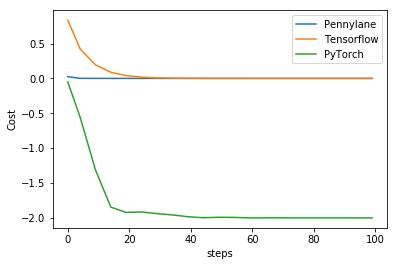

In [22]:
plt.plot(x,cost_gd,label='Pennylane')
plt.plot(x,cost_tf,label='Tensorflow')
plt.plot(x,cost_pt,label='PyTorch')
plt.xlabel("steps")
plt.ylabel("Cost")
plt.legend()
plt.show()

In some runs, you will see the optimization getting stuck in a local minima of energy (usually zero energy). Do not forget to restart the kernel before rerunning the file! 